# 인공 신경망

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/7-1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 패션 MNIST

In [2]:
from tensorflow import keras    # 텐서플로의 케라스 패키지 임포트, 패션 MNIST 데이터 다운로드

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data() # keras.datasets.fashion_mnist 모듈 아래에 load_data() 함수는 훈련 데이터와 테스트 데이터를 나누어서 반환해줌. 이 데이터는 각각 입력과 타깃의 쌍으로 구성됨.

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_input.shape, train_target.shape)
# 60000개의 이미지로 구성됨. 28*28 크기, 타깃또한 600000개의 원소가 있는 1차원 배열

(60000, 28, 28) (60000,)


In [4]:
print(test_input.shape, test_target.shape)
# 테스트 세트는 10000개의 이미지로 이루어져 있음

(10000, 28, 28) (10000,)


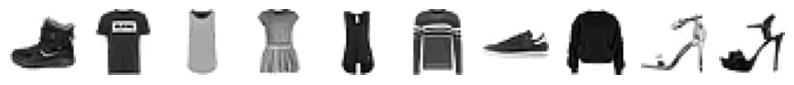

In [5]:
# sample 로 이미지 출력해봄
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r')
    axs[i].axis('off')
plt.show()

In [6]:
print([train_target[i] for i in range(10)])   # 10개 샘플의 타깃값을 리스트로 만들어 출력해봄
# 0:티셔츠 1:바지 2:스웨터 3:드레스 4:코드 5:샌달 6:셔츠 7:스니커즈 8:가방 9:앵클부츠

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


In [7]:
import numpy as np

print(np.unique(train_target, return_counts=True))    # unique함수로 레이블 당 샘플 수 확인해봄

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## 로지스틱 회귀로 패션 아이템 분류하기
train set이 60000개로 매우 많아 SGD를 사용한다. 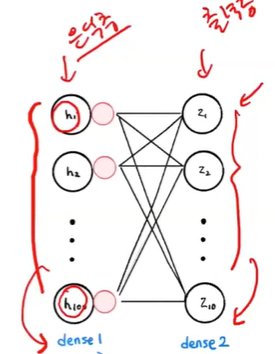

In [8]:
train_scaled = train_input / 255.0    # 이미지의 각 픽셀이 0~255 사이의 정수값 가짐. 양수 값으로 이루어진 이미지 전처리할 때 보통 255로 나누어 0~1 사이의 값으로 정규화 함
train_scaled = train_scaled.reshape(-1, 28*28)  # SGDClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들어야 한다. reshape()메서드를 사용하여 2차원을 1차원으로 펼침

In [9]:
print(train_scaled.shape)

(60000, 784)


In [10]:
# SGDClassifier와 cross_validate 함수를 사용하여 교차검증으로 성능을 확인해봄.
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)    # max_iter: 반복횟수

scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

0.8196000000000001


In [11]:
# SGDClassifier와 cross_validate 함수를 사용하여 교차검증으로 성능을 확인해봄.
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=20, random_state=42)    # max_iter: 반복횟수   # 반복횟수 20회 해도 성능이 크게 오르지 않음.

scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

# SGD Classifier 모델은 패션 MNIST 데이터의 클래스를 가능한 잘 구분할 수 있도록 10개의 방정식에 대한 모델 파라미터(가중치와 절편)를 찾는다.
# 각 클래스에 대한 선형 방정식을 모두 계산한 다음 소프트맥스 함수를 통화하여 각 클래스에 대한 확률을 얻을 수 있음.

0.8436666666666666


## 인공신경망

### 텐서플로와 케라스

In [12]:
import tensorflow as tf
# 텐서플로 : 구글이 공개한 딥러닝 라이브러리

In [13]:
from tensorflow import keras
# 텐서플로의 고수준 API : 케라스
# 딥러닝 라이브러리는 GPU를 사용하기 때문에 벡터, 행렬 연산 최적화 되어 있음. 곱셈과 덧셈연산에도 좋음

## 인공신경망으로 모델 만들기
- 출력층 : 신경망의 최종 값을 만든다
- 뉴런(유닛) : z값을 계산하는 단위
- 입력층 : 픽셀값 자체.

확률적 경사하강법을 사용한 로지스틱 회귀 모델이 가장 간단한 인공 신경망이다.

로지스틱회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용함.
- 이유1: 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증검수가 안정적
- 이유2; 교차 검증을 수행하기에는 train 시간이 너무 오래 걸리기 때문.
- 아래의 그림은 dense layer. 양쪽 뉴런이 모두 연결하고 있기 때문에 fully connected layer라고도 부른다.

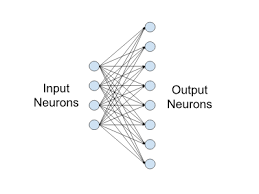

In [14]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [15]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [16]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


In [17]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))    # 순서대로 뉴런개수, 뉴런의 출력에 적용할 함수, 입력의 크기를 의미함.
# 뉴런 개수 : 10 . 10개의 패션 아이템
# 10개의 뉴런에서 출력되는 값을 확률로 바꾸기 위해서는 소프트맥스 함수를 사용함.
# 세 번째 값에서는 10개의 뉴런이 각각 몇 개의 입력을 받는지 튜를로 지정함.

# 활성화 함수 : 소프트맥스와 같이 뉴런의 선형 방정식 계산 결과의 적용되는 함수.

In [18]:
model = keras.Sequential(dense) # dense 층을 가진 신경망 모델을 생성함.

## 인공신경망으로 패션 아이템 분류하기

In [19]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')   # 케라스 모델 훈련 전 설정. 손실함수의 종류를 지정함. 그 다음 훈련과정에서 계산하고 싶은 측정값 지정.
# sparse_categorical_crossentropy를 사용하면 하나의 뉴런만으로 양성와 음성 클래스에 대한 크로스 엔트로피 손실을 모두 계산할 수 있음.

# 바지 샘플 정확히 분류 위해 신경망이 a2 의 출력을 가능한 높여야 함. 이 때 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만들기 위해서 원-핫 인코딩을 사용함.

# 정수로 된 타깃값을 사용해 크로스엔트로피 손실을 계산하는 것 : sparse_categorical_crossentropy
# 타깃값을 원-핫 인코딩으로 준비했다면 compile() 메서드에 손실함수를 categorical_crossentropy로 지정함.

In [20]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


In [21]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 9s 3ms/step - loss: 0.6069 - accuracy: 0.7947
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4742 - accuracy: 0.8382
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4508 - accuracy: 0.8474
Epoch 4/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4367 - accuracy: 0.8527
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4280 - accuracy: 0.8555


In [22]:
model.evaluate(val_scaled, val_target)  # 모델 성능 평가.

375/375 [==============================] - 1s 2ms/step - loss: 0.4526 - accuracy: 0.8465


[0.45262548327445984, 0.8464999794960022]

# 심층 신경망

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/7-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [23]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 2개의 층

In [24]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [25]:
from sklearn.model_selection import train_test_split

train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [26]:
# 인공신경망 모델에 층을 2개 추가해 봄.
# 입력층과 출력층 사이에 밀집층이 추가됨. 이렇게 입력층과 출력층 사이에 있는 모든 층을 은닉층이라고 부른다.
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784,))
dense2 = keras.layers.Dense(10, activation='softmax')

# 은닉층에는 활성화 함수가 표시되어 있음
# 활성화 함수 : 신경망 층의 선형방정식의 계산 값에 적용하는 함수.
# 출력층의 활성화 함수: 이진 분류일 결우 시그모이드 함수를 사용하고 다중 분류일 경우 소프트맥스 함수를 사용한다.
# 은닉층의 활성화 함수: 비교적 자유롭다. 시그모이드, 렐루 등을 사용한다.

# cf. 회귀를 위한 신경망의 출력층에서는 activation 매개변수에 아무런 값을 지정하지 않는다.

## 심층 신경망 만들기

In [27]:
# dense1 객체와 dense2 객체를 Sequential 클래스에 추가하여 심층 신경망 DNN을 만든다.
model = keras.Sequential([dense1, dense2])
# 여러 개의 층을 추가하려먼 리스트로 만들어 전달해야 한다. 주의할 것은 출력층을 가장 마지막에 두어야 한다는 것.

In [28]:
model.summary() # summary 메서드로 층에 대한 유용한 정보를 얻을 수 있음.
# 출력 크기 (None, 100) : 샘플의 개수. 은닉층의 뉴런 개수
# 샘플 개수가 None 인 이유 : 배치 차원, 미니배치 경사하강법을 사용하여 샘플 개수를 고정하지 않고 미니배치 매개변수로 바꿀 수 있도록 유연하게 대응하기 위함
# 100: 은닉층의 뉴런 개수. 즉 샘플마다 784의 픽셀값이 은닉층을 통과하면서 100개의 특성으로 압축된다.

# 784 * 100 + 100 = 78500 개의 파라미터
# 100 * 10 + 10 = 1010개의 파라미터
# 78500+1010 = 79510개의 총 모델 파라미터 개수
# 그 아래 경사하강법으로 훈련되지 않는 파라미터의 개수는 0으로 나옴.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 층을 추가하는 다른 방법

In [29]:
# 따로 dense에 저장하지 않고 Sequential 클래스의 생성자 안에서 바로 Dense 클래스의 객체를 만든다.
# 추가되는 층을 한 눈에 쉽게 알아보는 장점이 있다.
# name 매개변수 이용하여 층 구분이 쉽다.
model = keras.Sequential([
    keras.layers.Dense(100, activation='sigmoid', input_shape=(784,), name='hidden'),
    keras.layers.Dense(10, activation='softmax', name='output')
], name='패션 MNIST 모델')

In [30]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# add로 바로 동적으로 층을 전달할 수 있다.
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5710 - accuracy: 0.8064
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4132 - accuracy: 0.8509
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3776 - accuracy: 0.8646
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3530 - accuracy: 0.8732
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3344 - accuracy: 0.8782


## 렐루 활성화 함수
시그모이드 함수의 경우 오른쪽과 왼쪽 끝으로 갈수록 그래프가 누워있기 때문에 올바른 출력을 만드는 데 신속하게 대응하지 못한다. 따라서 다른 종류의 활성화 함수인 렐루가 제안됨. 입력이 양수일 경우 마치 활성화 함수가 없는 거서럼 그냥 입력을 통과시키고 음수일 경우에는 0으로 만든다.
- max(0, z)와 같이 쓸 수 있다.
- z가 0보다 크면 z를 출력하고 z가 0보다 작으면 0을 출력함.  
- 이미지 처리에서 뛰어나다.

In [34]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))   ## 케라스의 flatten 기능으로 차원을 1차원으로 바꿀 수 있다. 학습하는 층은 아님.
# 케라스의 Flatten 층을 신경망 모델에 추가하면 입력값의 차원을 짐작할 수 있다.  784의 입력이 첫 번째 은닉층에 전달되고 있음...
# 케라스 API는 입력 데이터에 대한 전처리 과정을 될 수 있으면 모델에 포함한다.
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [37]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5290 - accuracy: 0.8113
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3920 - accuracy: 0.8576
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3525 - accuracy: 0.8726
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3301 - accuracy: 0.8821
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3141 - accuracy: 0.8867


In [38]:
model.evaluate(val_scaled, val_target)  # 렐루 사용으로 성능 좋아짐을 확인함.

375/375 [==============================] - 1s 2ms/step - loss: 0.3683 - accuracy: 0.8726


[0.3683287501335144, 0.8725833296775818]

## 옵티마이저
- 하이퍼파라미터 : 모델이 학습하지 않아 사람이 지정해주어야 하는 파라미터
- ex. 은닉층의 개수, 뉴런의 개수, 활성화 함수, 층의 종류, 배치 사이즈, 매개변수, 에포크 메개변수 등

- 케라스에는 다양한 종류의 경사하강법 알고리즘을 제공한다 -> 옵티마이저 Optimizer
-  경사하강법 알고리즘, 알고리즘의 학습률 또한 하이퍼파라미터 이다.

In [39]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')
# SGD 옵티마이저 이용.

In [40]:
sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics='accuracy')
# 위의 코드와 동일함.

In [41]:
sgd = keras.optimizers.SGD(learning_rate=0.1)   # learning_rate를 지정하여 원하는 학습률로 조정할 수 있다.

### 기본 경사 하강법 옵티마이저
SGD, 모멘텀, 네스테로프 모멘텀
### 적응적 학습률 옵티마이저
RMSprop, Adam
Adagrad

In [42]:
sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
# SGD 클래스의 momentum 매개변수의 기본값은 0임. 이를 0보다 큰 값으로 지정하면 마치 이전의 그래디언트를 가속도처럼 사용하는 모멘텀 최적화(momentum optimization)을 사용한다. 보통 0.9 이상을 지정,

# 네스테로프 모멘텀은 모멘텀 최적화를 2번 반복하여 구현함. 대부분의 경우 네스테로프 모멘텀 최적화가 기본 확률적 경사하강법보다 더 나은 성능을 제공함.

In [43]:
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [44]:
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [45]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [46]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5266 - accuracy: 0.8154
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3957 - accuracy: 0.8588
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3564 - accuracy: 0.8705
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3280 - accuracy: 0.8796
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3085 - accuracy: 0.8851


In [47]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3485 - accuracy: 0.8763


[0.3484817445278168, 0.8762500286102295]

# 신경망 모델 훈련
<tensorflow.python.keras.callbacks.History at 0x7fef38bfc080>
> 노트북의 코드 셀은 print() 명령을 사용하지 않더라고 마지막 라인의 실행 결과를 자동으로 출력한다. 이 메시지는 fit() 메서드의 실행 결과를 출력한 것. => fit() 메서드가 History 클래스 객체를 반환한다.
- History 객채 : 훈련 과정에서 계산한 지표, 손실과 정확도 값이 저장되어 있어 이 값을 활용하면 그래프를 그릴 수 있다.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/7-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [48]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

In [49]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [50]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [51]:
model = model_fn()

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# fit() 메서드의 결과를 history 변수에 담는다.
# verbose : 훈련 과정 출력을 조정하는 매개변수. 1이 기본값. 에포크마다 진행 막대와 함께 손실 등의 지표가 출력됨.
# 2로 바꾸면 진행 막대를 빼고 출력함
# 0은 훈련 과정을 나타내지 않는다는 뜻
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [53]:
print(history.history.keys()) # history 딕셔너리에 어떤 값 있는지 확인. 손실과 정확도 들어 있음을 확인함.

dict_keys(['loss', 'accuracy'])


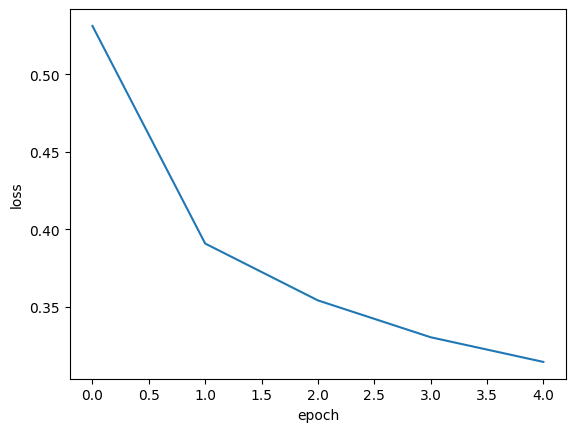

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

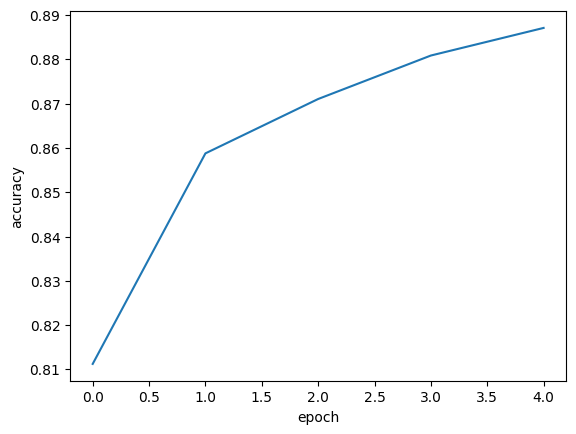

In [55]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [56]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)   # 에포크 20으로 늘림

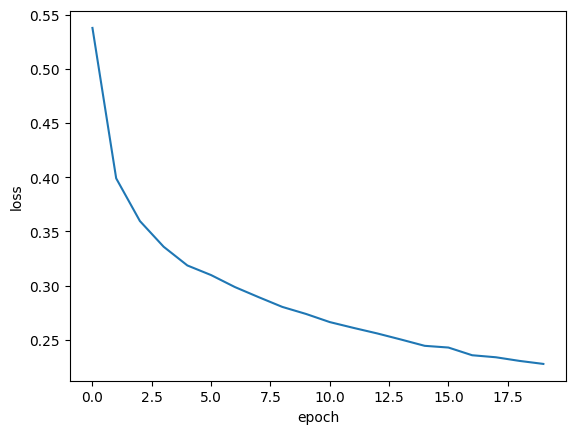

In [57]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실
에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요함.
- 인공 신경망 모델이 최적화하는 대상은 정확도가 아닌 손실함수. 따라서 모델이 잘 훈련되었는지 판단하려면 정확도 보다는 손실함수의 값을 확인하는 것이 낫다.

In [58]:
# 에포크마다 검증 손실을 계산하기 위해 fit() 메서드에 검증 데이터를 전달한다.
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [59]:
print(history.history.keys()) # history에 검증 세트에 대한 손실과 정확도 들어 있음을 확인함

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


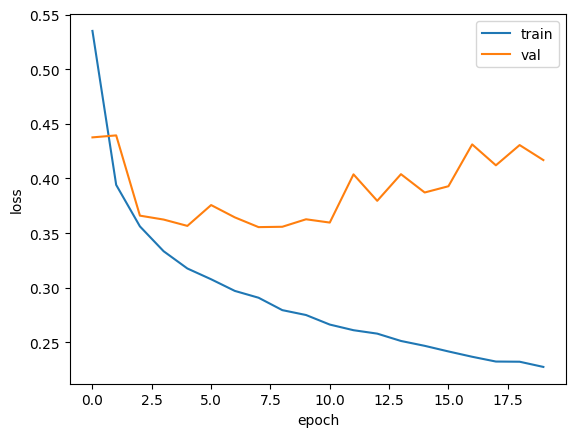

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [61]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',   # adam으로 적응적 학습률 사용하여 학습률 크기 조정 -> 과대적합 이전보다는 조금 줄음
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

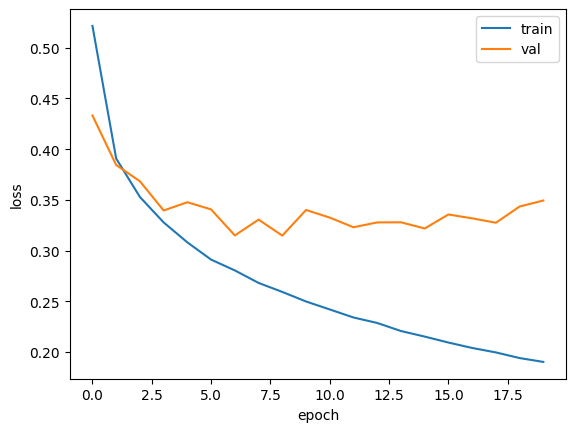

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃
과대적합 막기 위해 규제 방법을 사용함.
- 드롭아웃 : 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 ( 즉 뉴런의 출력을 0으로 만든다) 과대적합을 막는다.
- 얼마나 많은 뉴런을 드롭할건지 (percentage)는 또 다른 하이퍼파라미터가 된다.
- 드롭이 과대적합을 막는 이유 : 이전층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있도 모든 입력에 대해 주의를 기울여야 한다. 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있다.

In [63]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()   # 드롭아웃은 훈련되는 모델 파라미터 없음. 또한 입력과 출력의 크기가 같다. 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않음.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


훈련이 끝난 뒤 평가나 예측을 할 때는 드롭아웃을 적용하지 말아야 한다. 훈련된 모든 뉴런을 사용해야 올바른 예측 가능. 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다.

In [64]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

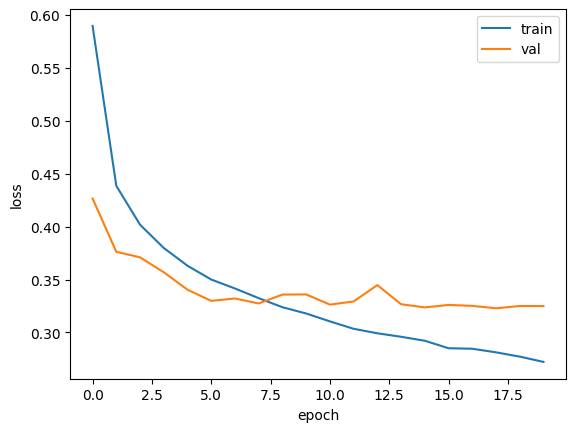

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 과대적합이 확실히 줄음을 확인할 수 있다. 10 이후에 과대적합 확인했으므로 epoch 10이 적당함을 확인.

## 모델 저장과 복원

In [66]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [67]:
model.save_weights('model-weights.h5')    # save_weights() 메서드로 훈련된 모델의 파라미터를 저장할 수 있다. .h5 확장자일 경우 HDF5 포맷으로 저장함

In [68]:
model.save('model-whole.h5')    # 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공함. 기본적으로 SavedModel 포맷으로 저장하지만 .h5 확장자일 경우 HDF5 포맷 저장.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Dec  3 11:58 model-weights.h5
-rw-r--r-- 1 root root 981176 Dec  3 11:58 model-whole.h5


In [70]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

In [71]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))
# 훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재함. 검증 정확도 확인함
# 케라스에서 예측을 수행하는 predict() 메서드는 10개의 클래스에 대한 확률을 반환함.

# 모델의 predict() 메서드에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용함. - 배열에서 가장 큰 인덱스를 반환함. axis=-1 : 배열의 마지막 차원을 따라 최댓값을 고른다. val set은 2차원이므로 마지막 차원은 1이 된다.

375/375 [==============================] - 1s 1ms/step
0.8775


In [72]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8775


[0.3387581706047058, 0.8774999976158142]

## 콜백
: 훈련 과정 중간에 어떤 작업을 수행할 수 있게 해는 객체. keras.callbacks 패키지 아래에 있는 클래스들.
- fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용함.

In [73]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [74]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

# ModelCheckpoint 콜백이 가장 낮은 점수의 모델을 자동으로 저장해 준다.

375/375 [==============================] - 1s 2ms/step - loss: 0.3177 - accuracy: 0.8865


[0.317716509103775, 0.8865000009536743]

조기종료 : 과대적합이 시작되기 전에 훈련을 미리 중지하는 것. epoch 횟수를 제한하는 역할이지만 규제방법 중 하나로 생각할 수 있다.

In [75]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [76]:
print(early_stopping_cb.stopped_epoch)    # 몇 번째 에포크에서 훈련이 중지되었는지 확인 가능

10


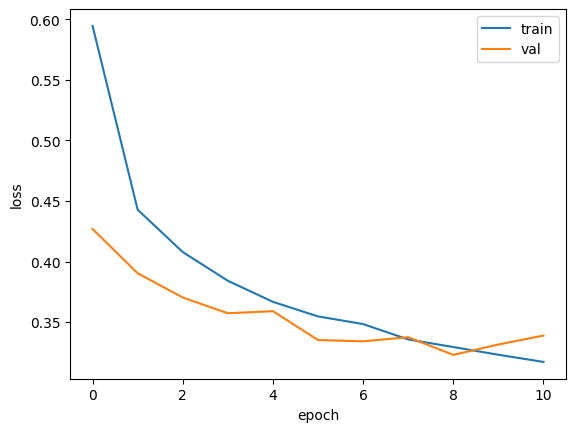

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 8번째 에포크에서 가장 낮은 손실, 10번째 에포크에서 훈련이 중지됨을 알 수 있다.

In [78]:
model.evaluate(val_scaled, val_target)    # 최종 성능 확인

375/375 [==============================] - 1s 2ms/step - loss: 0.3230 - accuracy: 0.8803


[0.32295477390289307, 0.8803333044052124]